<a href="https://colab.research.google.com/github/ferugit/speaker-recognition-exploration/blob/testing/ERR_with_less_audio_length.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
! pip install speechbrain

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.0/519.0 kB 29.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 58.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 17.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 109.1/109.1 kB 14.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 485.6/485.6 kB 45.0 MB/s eta 0:00:00


In [3]:
import numpy as np
import pandas as pd
from sklearn.metrics import roc_curve, auc
import torch
import time
import os
import itertools
import torchaudio
from torchsummary import summary
import matplotlib.pyplot as plt
import soundfile as sf
from speechbrain.pretrained import SpeakerRecognition
verification = SpeakerRecognition.from_hparams(source="speechbrain/spkrec-ecapa-voxceleb", savedir="pretrained_models/spkrec-ecapa-voxceleb")


In [17]:
def measure_frame_errors(gt, predictions):
    assert len(gt) == len(predictions), "length of ground truth list and predictions must be the same"
    fp, fn = 0, 0
    for i in range(len(gt)):
        if gt[i] != predictions[i]:
            if gt[i] == 1:
                fn += 1
            else:
                fp += 1
    return fp, fn


def get_frame_error_rate(gt, predictions):
    fp, fn = measure_frame_errors(gt, predictions)
    return 100*(fp+fn)/len(gt)


def get_detect_cost_function(gt, predictions, λ=0.5):
    fp, fn = measure_frame_errors(gt, predictions)
    return (1-λ)*fn + λ*fp


def get_fer_and_dcf(gt, predictions, λ=0.5):
    fp, fn = measure_frame_errors(gt, predictions)
    P_target, P_imposter = 0, 0
    for i in range(len(gt)):
        if gt[i] == 1:
            P_target += 1
        else:
            P_imposter += 1
    P_target = P_target/len(gt)
    P_imposter = P_imposter/len(gt)
    fer = 100*(fp+fn)/len(gt)
    dcf = (1-λ)*fn*P_target + λ*fp*P_imposter
    return fer, dcf

In [5]:
# unzip the data
!unzip /content/clips.zip -d /content/clips

Archive:  /content/clips.zip
   creating: /content/clips/clips/
  inflating: /content/clips/clips/aura_wuw_0RLZ3AUVOBZr8OqN_0000.wav  
  inflating: /content/clips/clips/aura_wuw_0RLZ3AUVOBZr8OqN_0001.wav  
  inflating: /content/clips/clips/aura_wuw_0RLZ3AUVOBZr8OqN_0002.wav  
  inflating: /content/clips/clips/aura_wuw_0RLZ3AUVOBZr8OqN_0003.wav  
  inflating: /content/clips/clips/aura_wuw_0RLZ3AUVOBZr8OqN_0004.wav  
  inflating: /content/clips/clips/aura_wuw_0RLZ3AUVOBZr8OqN_0005.wav  
  inflating: /content/clips/clips/aura_wuw_0RLZ3AUVOBZr8OqN_0006.wav  
  inflating: /content/clips/clips/aura_wuw_0RLZ3AUVOBZr8OqN_0007.wav  
  inflating: /content/clips/clips/aura_wuw_0RLZ3AUVOBZr8OqN_0008.wav  
  inflating: /content/clips/clips/aura_wuw_0RLZ3AUVOBZr8OqN_0009.wav  
  inflating: /content/clips/clips/aura_wuw_0RLZ3AUVOBZr8OqN_0010.wav  
  inflating: /content/clips/clips/aura_wuw_0RLZ3AUVOBZr8OqN_0011.wav  
  inflating: /content/clips/clips/aura_wuw_0RLZ3AUVOBZr8OqN_0012.wav  
  inflating: 

In [6]:
from IPython.display import Audio
wn = Audio('/content/clips/clips/aura_wuw_gCWOiMTUosewLJRs_0008.wav', autoplay=True)
display(wn)

In [7]:
df = pd.read_csv('/content/dataset.tsv', header = 0, sep = '\t')
A = df['Speaker_ID'].value_counts()



unique_speaker_ids = A.index
string_to_number = {string: idx for idx, string in enumerate(unique_speaker_ids)}

# Map the 'Speaker_ID' column using the dictionary
df['Speaker_ID'] = df['Speaker_ID'].map(string_to_number)



B = df['Speaker_ID'].value_counts()


In [8]:
prefix = "/content/clips/clips"

# Assuming you have a DataFrame called 'df' with a column 'path' containing the file paths
audio_files = df['Filename'].tolist()

# Add the prefix to each file path and keep only .wav files
audio_files = [os.path.join(prefix, f) for f in audio_files if f.endswith(".wav")]


In [9]:
for i in audio_files:
  # Set the desired duration in seconds
  desired_duration = 1.5 # seconds

  # Load the audio file
  audio_file = os.path.join(i)
  audio, sample_rate = sf.read(audio_file)

  # Calculate the number of samples for the desired duration
  desired_samples = int(desired_duration * sample_rate)

  # Calculate the start sample index for the middle portion
  start_index = max(0, len(audio) // 2 - desired_samples // 2)

  # Crop the audio to the desired duration
  cropped_audio = audio[start_index : start_index + desired_samples] # take exactly from the middle
  #cropped_audio = audio[:desired_samples] # take from the start of the audio


  # Save the cropped audio to a new file
  output_file = os.path.join(i)
  sf.write(output_file, cropped_audio, sample_rate)

In [10]:
speaker_files = []

A = df['Speaker_ID'].to_list()
B = df['Filename'].to_list()
speaker_files = list(zip(A, B))

prefix = "/content/clips/clips/"


pairs = []
for speaker1, file1 in speaker_files:
    for speaker2, file2 in speaker_files:
        pairs.append([prefix+file1, prefix+file2, speaker1, speaker2])

In [11]:
scores = []
true_labels = []
predictions = []
for pair in pairs[:500]:
    file1, file2, speaker1, speaker2 = pair
    print(f"{speaker1} and {speaker2}")
    score, prediction = verification.verify_files(os.path.join(file1), os.path.join(file2))
    scores.append(score)

    # Label: 1 if same speaker, 0 if different speakers
    label = int(speaker1 == speaker2)
    true_labels.append(label)
    predictions.append(int(prediction))

true_labels = np.array(true_labels)
predictions = np.array(predictions)
# Compute ROC curve and ROC area
fpr, tpr, threshold = roc_curve(true_labels, scores)


fnr = 1 - tpr
# the threshold of fnr == fpr
EER = fpr[np.nanargmin(np.absolute((fnr - fpr)))]

eer_threshold = threshold[np.nanargmin(np.absolute((fnr - fpr)))]
print(f"Equal Error Rate = {EER}, and the treshold = {eer_threshold}")



roc_auc = auc(fpr, tpr)

0 and 0


/usr/local/lib/python3.10/dist-packages/torch/functional.py:641: UserWarning: stft with return_complex=False is deprecated. In a future pytorch release, stft will return complex tensors for all inputs, and return_complex=False will raise an error.
Note: you can still call torch.view_as_real on the complex output to recover the old return format. (Triggered internally at ../aten/src/ATen/native/SpectralOps.cpp:862.)
  return _VF.stft(input, n_fft, hop_length, win_length, window,  # type: ignore[attr-defined]


0 and 0
0 and 0
0 and 0
0 and 0
0 and 0
0 and 0
0 and 0
0 and 0
0 and 0
0 and 0
0 and 0
0 and 0
0 and 0
0 and 0
0 and 0
0 and 0
0 and 61
0 and 61
0 and 61
0 and 61
0 and 61
0 and 61
0 and 61
0 and 61
0 and 61
0 and 61
0 and 61
0 and 61
0 and 61
0 and 61
0 and 61
0 and 61
0 and 48
0 and 48
0 and 48
0 and 48
0 and 48
0 and 48
0 and 48
0 and 48
0 and 48
0 and 48
0 and 48
0 and 48
0 and 48
0 and 48
0 and 48
0 and 48
0 and 48
0 and 47
0 and 47
0 and 47
0 and 47
0 and 47
0 and 47
0 and 47
0 and 47
0 and 47
0 and 47
0 and 47
0 and 47
0 and 47
0 and 47
0 and 47
0 and 47
0 and 47
0 and 46
0 and 46
0 and 46
0 and 46
0 and 46
0 and 46
0 and 46
0 and 46
0 and 46
0 and 46
0 and 46
0 and 46
0 and 46
0 and 46
0 and 46
0 and 46
0 and 46
0 and 45
0 and 45
0 and 45
0 and 45
0 and 45
0 and 45
0 and 45
0 and 45
0 and 45
0 and 45
0 and 45
0 and 45
0 and 45
0 and 45
0 and 45
0 and 45
0 and 45
0 and 44
0 and 44
0 and 44
0 and 44
0 and 44
0 and 44
0 and 44
0 and 44
0 and 44
0 and 44
0 and 44
0 and 44
0 and 44

/usr/local/lib/python3.10/dist-packages/sklearn/utils/_array_api.py:185: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  array = numpy.asarray(array, order=order, dtype=dtype)
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_array_api.py:185: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  array = numpy.asarray(array, order=order, dtype=dtype)


In [16]:
fer, dct = get_fer_and_dcf(true_labels, predictions)
print (f"frame error rate = {fer}, and cost function = {dct}")


length of one is 500 and the other length is 500
frame error rate = 5.4, and cost function = 13.5


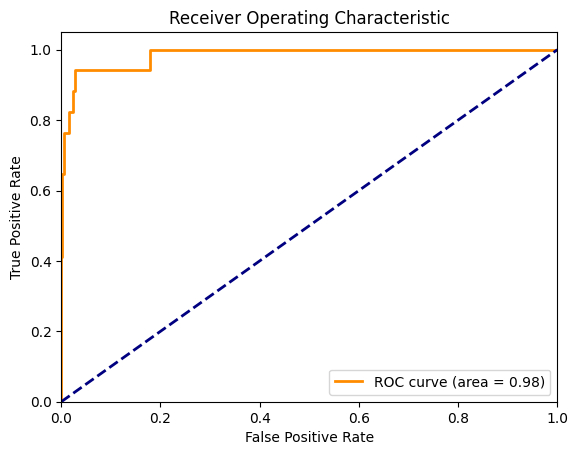

In [ ]:
# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color="darkorange", lw=2, label="ROC curve (area = %0.2f)" % roc_auc)
plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic")
plt.legend(loc="lower right")
plt.show()